In [1]:

import transformers
import torch
from vllm import LLM, SamplingParams
import os
from src.llm.PredictionUtils import init_model_and_tokenizer,llm_gen

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"

In [2]:
tensor_parallel_size = 8
#lora推論がうまくいかない
model= LLM(model=model_id,
           enable_lora=True,
        trust_remote_code=True,
        max_model_len=2000,
        tensor_parallel_size=tensor_parallel_size,
 max_lora_rank=64,
           )

INFO 09-19 13:14:30 config.py:904] Defaulting to use mp for distributed inference
INFO 09-19 13:14:30 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-70B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-70B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llam

Loading safetensors checkpoint shards:   0% Completed | 0/30 [00:00<?, ?it/s]


(VllmWorkerProcess pid=659722) INFO 09-19 13:14:49 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659723) INFO 09-19 13:14:49 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659724) INFO 09-19 13:14:50 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659726) INFO 09-19 13:14:51 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659728) INFO 09-19 13:14:52 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 13:14:52 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659727) INFO 09-19 13:14:53 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=659725) INFO 09-19 13:14:54 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 13:15:00 distributed_gpu_executor.py:57] # GPU blocks: 81384, # CPU blocks: 6553
(VllmWorkerProcess pid=659724) INFO 09-19 13:15:03 

In [3]:
from vllm.lora.request import LoRARequest

In [4]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="train")
ds=ds.shuffle(seed=1)
len(ds)

7241

In [5]:

train_ds=ds.select(range(7000))
test_ds=ds.select(range(7000,7200))
train_ds[0]


{'CompName': 'unknown',
 'SMILES': 'CC1=CC=C(C=C1)O',
 'Property': 'Vapor pressure',
 'Value': 0.11,
 'unit': '[kPa]',
 'Source': 'Wikipedia/Wikidata'}

In [6]:
import transformers
tokenizer=transformers.AutoTokenizer.from_pretrained(model_id)

In [20]:
import random
prompt_list=[]
problems=[]
n_records=500
target_ds=train_ds
target_ds=test_ds

n_records=min(n_records,len(target_ds))

for i in range(n_records):
    random.seed(i)
    record=random.choice(target_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)

prompt_list[0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPredict Density [g/cm3] for unknown (Compound X) with SMILES C1CCC2(CCCCC2(C1)[H])[H]. The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction.<|eot_id|>assistant\n\n#Reason\n'

In [21]:
def predict_lora(model,prompt_list,
        lora_model,lora_id,
        do_lora=True,
        ):
    if do_lora:
        print("using: ",lora_model)
        outputs = model.generate(
            prompt_list,
            SamplingParams(
            temperature=0.0,
            max_tokens=1024,
        ),
            lora_request=LoRARequest("adapter", lora_id, lora_path=lora_model)
        )
    else:
        print("not using lora")
        outputs = model.generate(
            prompt_list,
            SamplingParams(
            temperature=0.0,
            max_tokens=1024,
        ),
        )
    predicted_texts=[i.outputs[0].text.strip() for i in outputs]
    return predicted_texts

In [22]:
def parse_prediction(predicted_texts):
    predicted_vals=[]
    good_records=[]
    for i in range(len(predicted_texts)):
        pred=predicted_texts[i].split("#Prediction")[-1]
        pred=pred.split(" [")[0].strip()

        strip_list=[
            "kJ/mol",
            "°C"," oC"," g/cm3"," g/cm"," eV"," cm^3/mol"," × 10^-6",
        ]
        for s in strip_list:
            pred=pred.split(s)[0].strip()

        if " " in pred:
            pred=pred.split(" ")[-1]
        if "\n" in pred:
            pred=pred.split("\n")[-1]
        if "**" in pred:
            pred=pred.split("**")[-1]
        
        predicted_vals.append(pred)

        problems[i]["predicted"]=pred
        problems[i]["predicted_text"]=predicted_texts[i]
        try:
            problems[i]["Value"]=float(problems[i]["Value"])
            error = abs((problems[i]["Value"]-float(problems[i]
                        ["predicted"]))/problems[i]["Value"])
            problems[i]["error_rate"] = error
            good_records.append(problems[i])
        except Exception as e:
            print(e)
            continue

    return good_records



In [23]:

#lora_model="output_0919_threshold_0.1"
#predicted_texts=predict_lora(model,prompt_list,lora_model)
#good_records=parse_prediction(predicted_texts)

In [24]:
import glob
from tqdm import tqdm
lora_model_list=glob.glob("output_0919_threshold_0.1/checkpoint-*")
lora_model_list=glob.glob("output0919_threshold_0.1_lora_kqvo_proj/checkpoint-*")
lora_model_list= sorted(lora_model_list, key=lambda x: int(x.split('-')[-1]))

prediction_dict={}

cnt=100
for lora_model in tqdm(lora_model_list[:]):
    cnt+=1
    predicted_texts=predict_lora(model,prompt_list,lora_model,cnt)
    good_records=parse_prediction(predicted_texts)
    prediction_dict[lora_model]=good_records

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_659641/871330620.py:13: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  lora_request=LoRARequest("adapter", lora_id, lora_path=lora_model)


using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-5


 14%|█▍        | 1/7 [01:00<06:03, 60.56s/it]

using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-10


 29%|██▊       | 2/7 [01:57<04:51, 58.35s/it]

could not convert string to float: '49.5.0'
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-15


 43%|████▎     | 3/7 [02:55<03:52, 58.13s/it]

using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-20


 57%|█████▋    | 4/7 [04:04<03:07, 62.51s/it]

could not convert string to float: '10^-'
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-25


 71%|███████▏  | 5/7 [05:03<02:02, 61.31s/it]

using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-30


 86%|████████▌ | 6/7 [06:11<01:03, 63.69s/it]

could not convert string to float: '('
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-33


100%|██████████| 7/7 [07:22<00:00, 63.17s/it]

could not convert string to float: '('


In [25]:
predicted_texts=predict_lora(model,prompt_list,lora_model,cnt,do_lora=False)
good_records=parse_prediction(predicted_texts)
prediction_dict["original"]=good_records

not using lora


Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 200/200 [00:40<00:00,  4.89it/s, est. speed input: 523.51 toks/s, output: 1425.80 toks/s]

could not convert string to float: '105-110'
could not convert string to float: '120-150'
could not convert string to float: '120-150'
could not convert string to float: '5-7'
could not convert string to float: 'mPas'
could not convert string to float: 'mPa·s'
could not convert string to float: '(20'
could not convert string to float: 'kPa'
could not convert string to float: '400-420'
could not convert string to float: 'mixture.'
could not convert string to float: '(20'
could not convert string to float: '105-115'
could not convert string to float: '60-70'
could not convert string to float: '40-50'
could not convert string to float: '80-100'
could not convert string to float: '10^-6'
could not convert string to float: '220-250'
could not convert string to float: 'kPa'
could not convert string to float: '220-250'
could not convert string to float: 'kPa'
could not convert string to float: '220-250'
could not convert string to float: '110-130'
could not convert string to float: '10^-6'
co

In [28]:
import json 
#with open("data/predict/0919prediction_dict_kqvo_proj.json","w") as f:
#    json.dump(prediction_dict,f,indent=2)

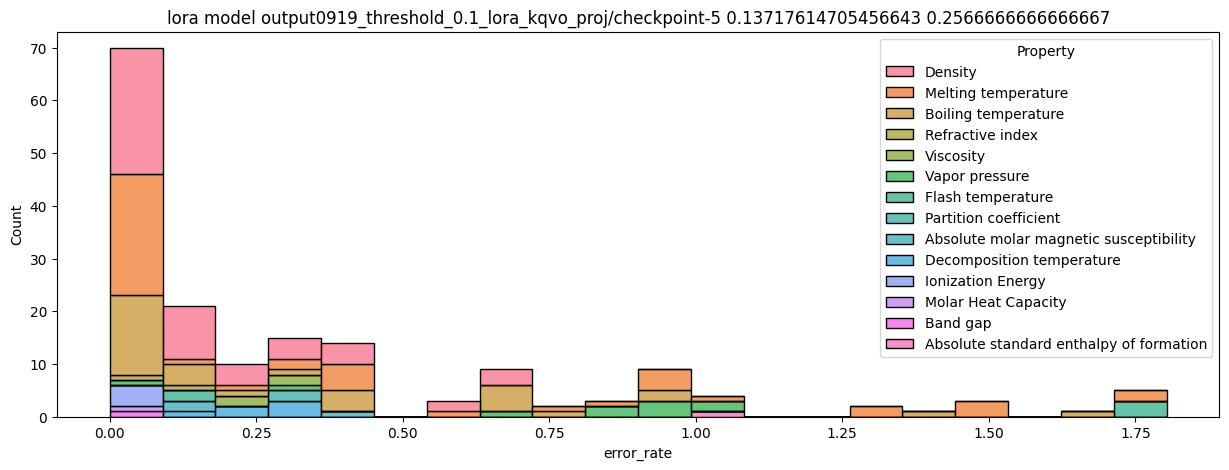

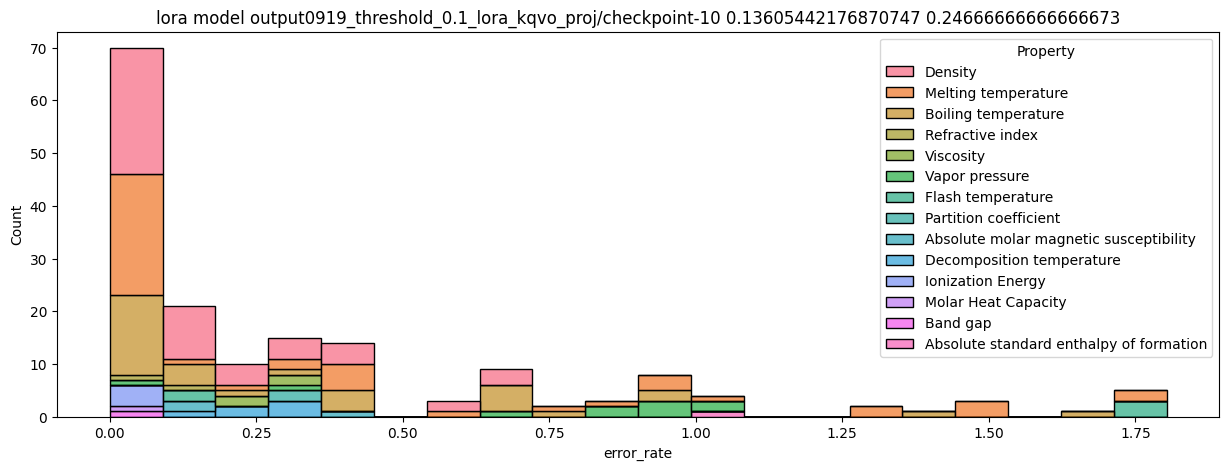

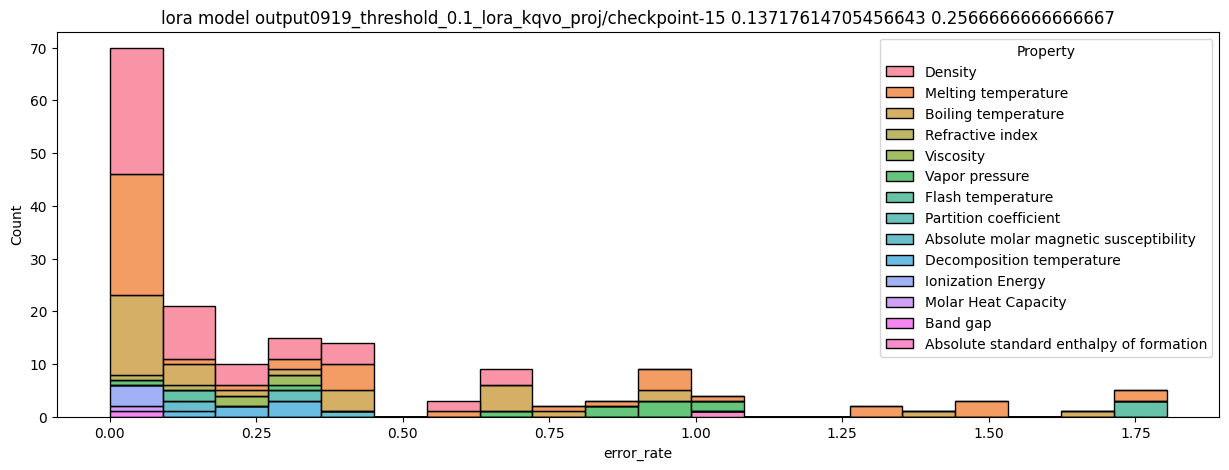

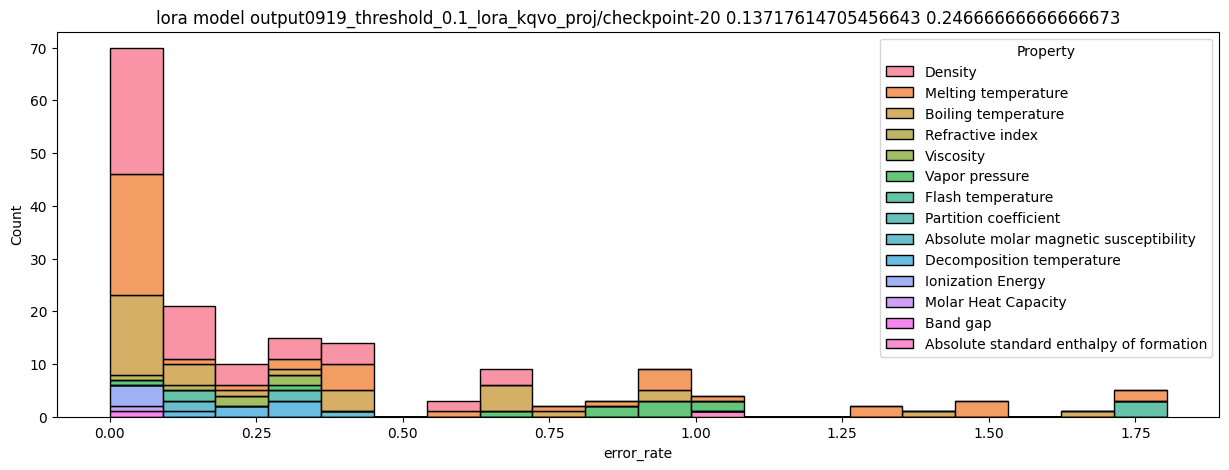

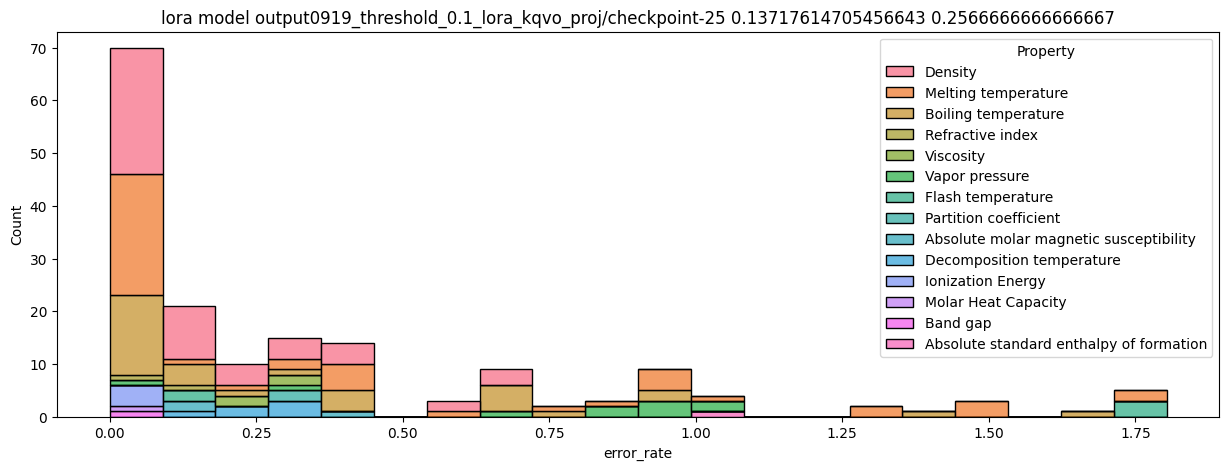

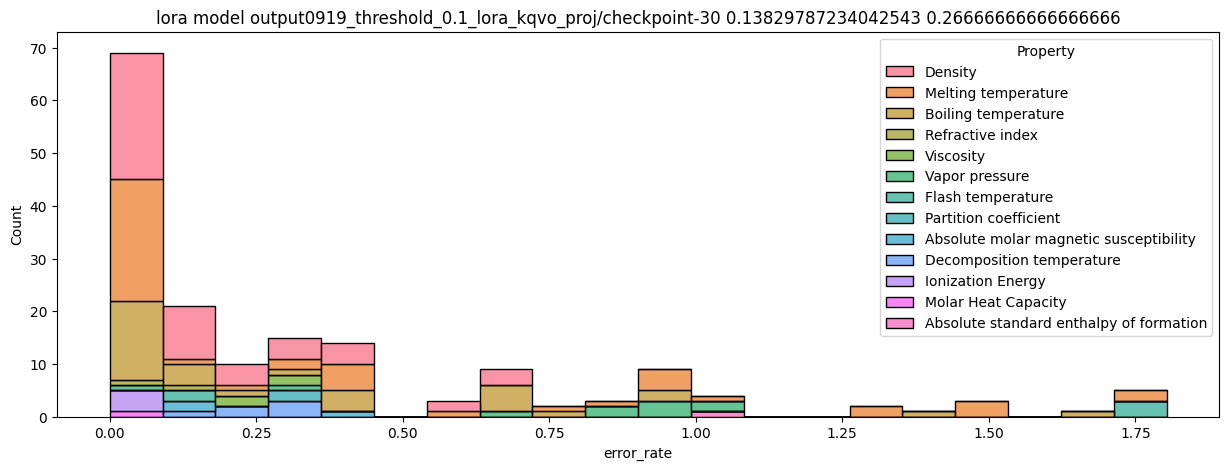

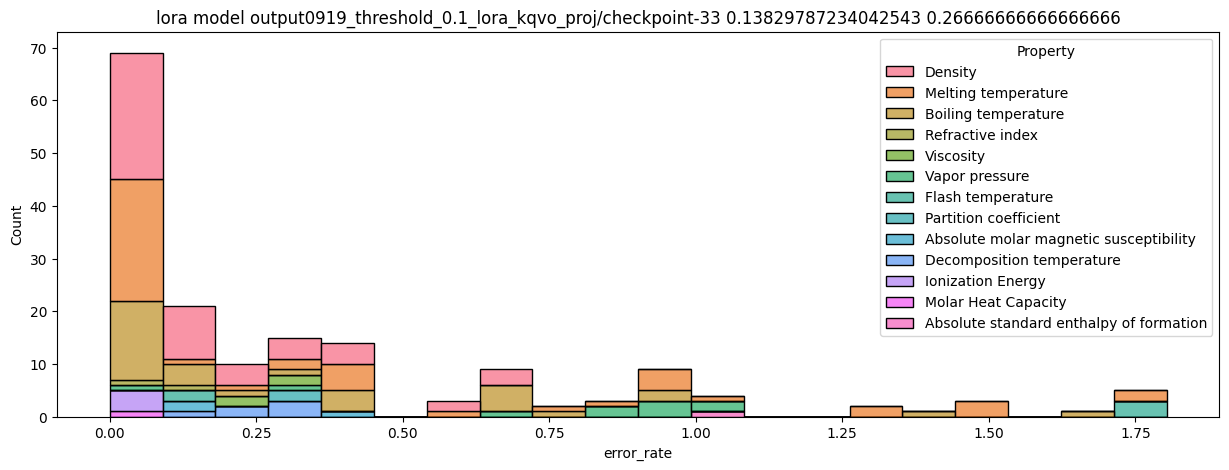

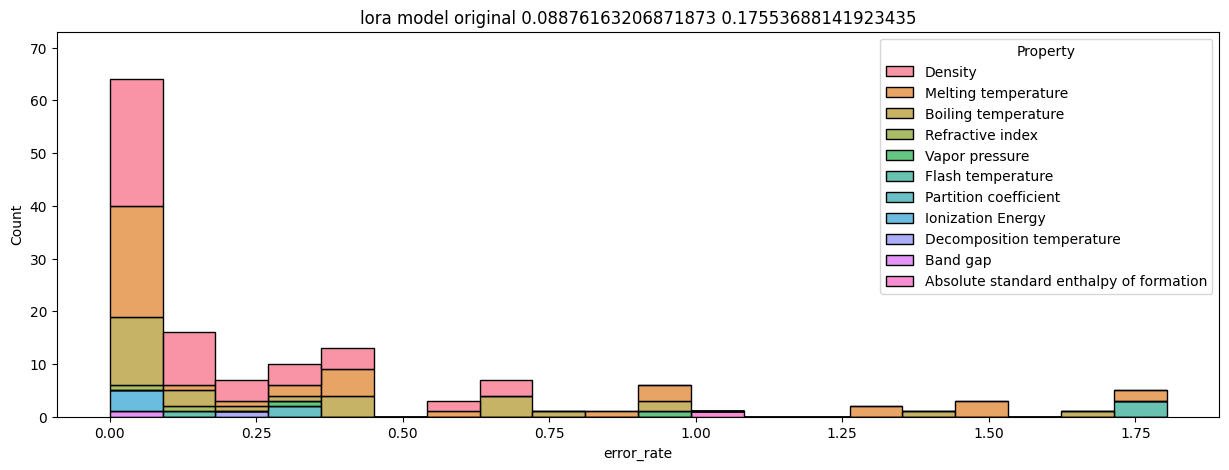

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for lora_name,good_records in prediction_dict.items():

    df=pd.DataFrame(good_records)

    plt.figure(figsize=(15, 5))
    sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
                bins=20)


    s_df=df[df["error_rate"]<1]
    median1=s_df["error_rate"].median()
    median2=df["error_rate"].median()
    plt.title(f"lora model {lora_name} {median1} {median2}")
    plt.ylim(0,73)